In [123]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

In [124]:
ticker_symbol = 'DX-Y.NYB'
ticker = yf.Ticker(ticker_symbol)
df = ticker.history(period='5y').reset_index(drop=False)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-11-05 00:00:00-05:00,93.339996,93.550003,92.489998,92.529999,0,0.0,0.0
1,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003,0,0.0,0.0
2,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003,0,0.0,0.0
3,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000,0,0.0,0.0
4,2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001,0,0.0,0.0
...,...,...,...,...,...,...,...,...
1253,2025-10-30 00:00:00-04:00,99.139999,99.720001,98.919998,99.529999,0,0.0,0.0
1254,2025-10-31 00:00:00-04:00,99.489998,99.839996,99.419998,99.800003,0,0.0,0.0
1255,2025-11-03 00:00:00-05:00,99.750000,99.989998,99.709999,99.870003,0,0.0,0.0
1256,2025-11-04 00:00:00-05:00,99.980003,100.260002,99.739998,100.220001,0,0.0,0.0


In [125]:
df1 = df.drop(columns=['Volume','Dividends','Stock Splits'])
df1

,Date,Open,High,Low,Close
0,2020-11-05 00:00:00-05:00,93.339996,93.550003,92.489998,92.529999
1,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003
2,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003
3,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000
4,2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001
...,...,...,...,...,...
1253,2025-10-30 00:00:00-04:00,99.139999,99.720001,98.919998,99.529999
1254,2025-10-31 00:00:00-04:00,99.489998,99.839996,99.419998,99.800003
1255,2025-11-03 00:00:00-05:00,99.750000,99.989998,99.709999,99.870003
1256,2025-11-04 00:00:00-05:00,99.980003,100.260002,99.739998,100.220001


In [126]:
fig = px.line(df1, x='Date', y=['Open','High','Low','Close'])
fig.show()

# Stationarity:
From the above graph we can see that there is a clear uprising trend in the timeseries starting from the end of 2021. At the end of 2022, the timeseries seem to stabilize around a new and higher mean value, compared to the initial one. There might be some seasonality as we see that in some periods there seems to be an upwards trajectory followed by a downwards one. However, it is not particularly clear.

In general, we can assume that the timeseries are non-stationary.

If we try to fit a regressor on a non-stationary timeseries then the model will not be able to generalize well. During training, these algorithms usually try to minimize some kind of error based on a mean value. However, if a core statistic of our data changes significantly (like the mean value) then the model would not be able to capture them efficiently. In essence, it will either model some of the data correctly, or none of them at all in an attempt to handle these unexpected changes.

For example, for the first part of 2021 the timeseries seem to fluctuate between 90 and 95. From the the beginning of 2023 till the end of 2024 they seem to fluctuate between 100 and 105. A regressor would not be able to model these timeseries correctly, as it would not be able to expect how the time points would change over time. It might model a part of the timeseries correctly or fail to model any parts of it correctly.

By zooming in the period between 6/2025 and 7/2025 we can see that the timeseries seem to have a slight downwards trend. The window of the data is too small to make clear assumptions, especially since these are daily observations. This trend might appear due to many social / economic events in that period.

# Data for one day to predict the next one?
Let's consider the scenario that we would like to predict the prices of the following day, but we only have the values of the  current. It would be very difficult to produce accurate forecasts, since we only have information about one day. If our data are daily (one observation per day) then it becomes very challenging. Most likely, the model would just copy the current day into the following one. Depending on the phenomenon we are studying and the data that we have, we need plenty of observations that can depict its characteristics. If one day's of data do that efficiently (the timeseries is almost identical every day), then it might be enough. However, in most real world problems, more observations are needed.

# Splitting a timeseries into Train - Test sets:

In timeseries analysis, the order of the observations plays a significant part in our study. Therefore, we must not split the dataset randomly as we risk throwing away an important factor of the data, the time. Thus, we should split them chronologically.

In [127]:
train_df = df1[df1['Date']< '2024-01-01']
train_df

,Date,Open,High,Low,Close
0,2020-11-05 00:00:00-05:00,93.339996,93.550003,92.489998,92.529999
1,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003
2,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003
3,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000
4,2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001
...,...,...,...,...,...
787,2023-12-22 00:00:00-05:00,101.760002,101.900002,101.430000,101.699997
788,2023-12-26 00:00:00-05:00,101.650002,101.769997,101.449997,101.470001
789,2023-12-27 00:00:00-05:00,101.550003,101.570000,100.830002,100.989998
790,2023-12-28 00:00:00-05:00,100.870003,101.300003,100.620003,101.230003


In [128]:
test_df = df1[df1['Date'].dt.year == 2024]
test_df

,Date,Open,High,Low,Close
792,2024-01-02 00:00:00-05:00,101.419998,102.250000,101.339996,102.199997
793,2024-01-03 00:00:00-05:00,102.150002,102.730003,102.080002,102.459999
794,2024-01-04 00:00:00-05:00,102.459999,102.529999,102.150002,102.419998
795,2024-01-05 00:00:00-05:00,102.400002,103.099998,101.910004,102.410004
796,2024-01-08 00:00:00-05:00,102.440002,102.620003,102.080002,102.209999
...,...,...,...,...,...
1039,2024-12-24 00:00:00-05:00,108.160004,108.300003,107.919998,108.260002
1040,2024-12-26 00:00:00-05:00,108.169998,108.300003,108.029999,108.129997
1041,2024-12-27 00:00:00-05:00,108.080002,108.199997,107.870003,108.000000
1042,2024-12-30 00:00:00-05:00,108.010002,108.379997,107.739998,108.129997


In [129]:
train_df = train_df.drop(columns=['Date'])
test_df = test_df.drop(columns=['Date'])
train_df.columns , test_df.columns

(Index(['Open', 'High', 'Low', 'Close'], dtype='object'),
 Index(['Open', 'High', 'Low', 'Close'], dtype='object'))

The following function creates the necessary windows for timeseries forecasting.

In [130]:
def prepare_data (df,N):
  x=[]
  y=[]
  for i in range(len(df)-N):
    x.append(df.iloc[i:i+N,:])
    y.append(df.iloc[i+N,3])

  x = np.array(x)
  y = np.array(y)

  return x,y

# What number should the N be?

How many of the past observations should we use to forecast the following day? That depends on the structure of the data and how repsesentative they are. For daily observations we can start experimenting with a small number, like 3-5 and adapt if necessary.

If the forecast horizon is bigger (one month), then the N should increase as well, so as to use data of at least 1-2 months (30-60).  

In [131]:
train_df.head(6)

,Open,High,Low,Close
0,93.339996,93.550003,92.489998,92.529999
1,92.570000,92.820000,92.180000,92.230003
2,92.239998,92.959999,92.129997,92.730003
3,92.760002,92.970001,92.599998,92.750000
4,92.699997,93.209999,92.610001,93.040001
5,93.010002,93.139999,92.779999,92.959999


In [132]:
x_train , y_train = prepare_data (train_df,5)
x_train[0],y_train[0]

(array([[93.33999634, 93.55000305, 92.48999786, 92.52999878],
        [92.56999969, 92.81999969, 92.18000031, 92.23000336],
        [92.23999786, 92.95999908, 92.12999725, 92.73000336],
        [92.76000214, 92.97000122, 92.59999847, 92.75      ],
        [92.69999695, 93.20999908, 92.61000061, 93.04000092]]),
 np.float64(92.95999908447266))

In [133]:
print(x_train.shape)
x_reshaped = x_train.reshape(x_train.shape[0],-1)
print(x_reshaped.shape)
x_reshaped[0]

(787, 5, 4)
(787, 20)


array([93.33999634, 93.55000305, 92.48999786, 92.52999878, 92.56999969,
       92.81999969, 92.18000031, 92.23000336, 92.23999786, 92.95999908,
       92.12999725, 92.73000336, 92.76000214, 92.97000122, 92.59999847,
       92.75      , 92.69999695, 93.20999908, 92.61000061, 93.04000092])

In [134]:
x_reshaped.shape , y_train.shape

((787, 20), (787,))

In [135]:
x_test , y_test = prepare_data (test_df,5)
x_test_reshaped = x_test.reshape(x_test.shape[0],-1)
x_test_reshaped.shape , y_test.shape

((247, 20), (247,))

In [136]:
reg = LinearRegression().fit(x_reshaped,y_train)
y_pred_reg = reg.predict(x_test_reshaped)
mae_reg_test = mean_absolute_error(y_test, y_pred_reg)
y_pred_reg_train = reg.predict(x_reshaped)
mae_reg_train = mean_absolute_error(y_train, y_pred_reg_train)
print(f'Linear Regressor: Train MAE:{mae_reg_train:.2f} ,Test MAE:{mae_reg_test:.2f} ')

Linear Regressor: Train MAE:0.35 ,Test MAE:0.28 


In [137]:
rf = RandomForestRegressor().fit(x_reshaped,y_train)
y_pred_rf = rf.predict(x_test_reshaped)
mae_rf_test = mean_absolute_error(y_test, y_pred_rf)
y_pred_rf_train = rf.predict(x_reshaped)
mae_rf_train = mean_absolute_error(y_train, y_pred_rf_train)
print(f'Random Forest Regressor: Train MAE:{mae_rf_train:.2f} ,Test MAE:{mae_rf_test:.2f} ')

Random Forest Regressor: Train MAE:0.15 ,Test MAE:0.32 


In [138]:
bag = BaggingRegressor().fit(x_reshaped,y_train)
y_pred_bag = bag.predict(x_test_reshaped)
mae_bag_test = mean_absolute_error(y_test, y_pred_bag)
y_pred_bag_train = bag.predict(x_reshaped)
mae_bag_train = mean_absolute_error(y_train, y_pred_bag_train)
print(f'Bagging Regressor: Train MAE:{mae_bag_train:.2f} ,Test MAE:{mae_bag_test:.2f} ')

Bagging Regressor: Train MAE:0.16 ,Test MAE:0.34 


In [139]:
xb = xgb.XGBRegressor().fit(x_reshaped,y_train)
y_pred_xb = xb.predict(x_test_reshaped)
mae_xb_test = mean_absolute_error(y_test, y_pred_xb)
y_pred_xb_train = xb.predict(x_reshaped)
mae_xb_train = mean_absolute_error(y_train, y_pred_xb_train)
print(f'XGBoost: Train MAE:{mae_xb_train:.2f} ,Test MAE:{mae_xb_test:.2f} ')

XGBoost: Train MAE:0.02 ,Test MAE:0.38 


In [140]:
estimators = [
    ('lin', LinearRegression()),
    ('dt', DecisionTreeRegressor())
]
sreg = StackingRegressor(estimators=estimators).fit(x_reshaped,y_train)
y_pred_sreg = sreg.predict(x_test_reshaped)
mae_sreg_test = mean_absolute_error(y_test, y_pred_sreg)
y_pred_sreg_train = sreg.predict(x_reshaped)
mae_sreg_train = mean_absolute_error(y_train, y_pred_sreg_train)
print(f'Stacking Regressor: Train MAE:{mae_sreg_train:.2f} ,Test MAE:{mae_sreg_test:.2f} ')


Stacking Regressor: Train MAE:0.36 ,Test MAE:0.29 


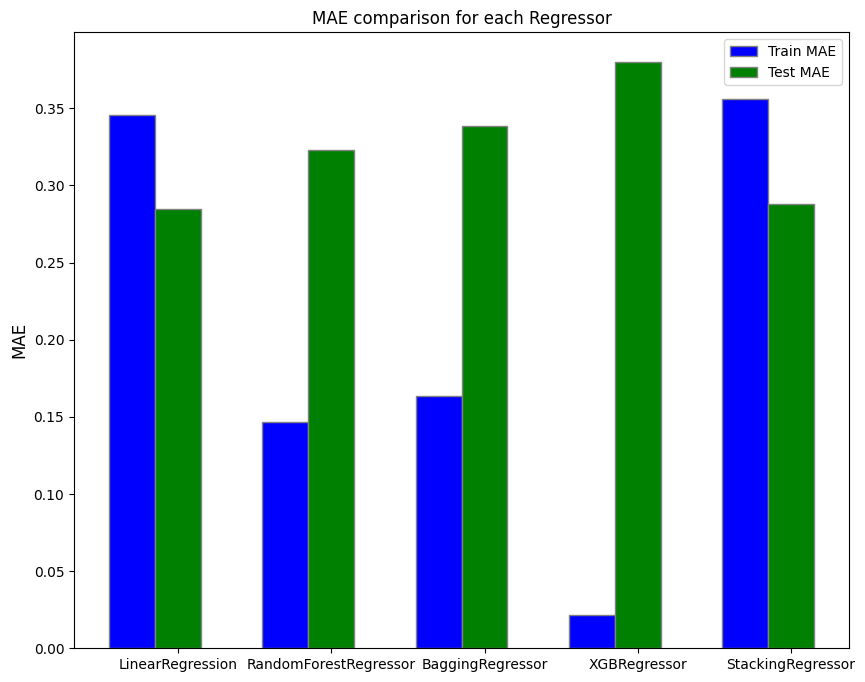

In [141]:
bar_width = 0.3
fig = plt.subplots(figsize =(10, 8))

train_errors = [mae_reg_train , mae_rf_train, mae_bag_train, mae_xb_train, mae_sreg_train]
test_errors = [mae_reg_test , mae_rf_test, mae_bag_test, mae_xb_test, mae_sreg_test]

names = ['LinearRegression', 'RandomForestRegressor', 'BaggingRegressor', 'XGBRegressor', 'StackingRegressor']

bar1 = np.arange(len(train_errors))
bar2 = [x + bar_width for x in bar1]

plt.bar(bar1, train_errors, color ='b', width = bar_width,edgecolor ='grey', label ='Train MAE')
plt.bar(bar2, test_errors, color ='g', width = bar_width,edgecolor ='grey', label ='Test MAE')

plt.ylabel('MAE', fontsize = 12)
plt.xticks([b + bar_width for b in range(len(train_errors))], names)
plt.title("MAE comparison for each Regressor")

plt.legend()
plt.show()

We can see that the Stacking and the Linear regressors appear to have similar performance, with the lowest errors on the test set. In addition, it is worth mentioning that Random Forest, Baging and XGB regressors appear to have overfitted the training data, as the test errors seem to be much bigger that the train errors.

# Imporving performance

By creating new features we could attempt to improve the performance of the models. For example, the Day and Month could impact the way that the timeseries change, as they may represent a change in human behavior and overall in economy. Thus, it might be interesting to test if adding them to the dataset lowers the errors.

In [142]:
df1['Day'] = df1['Date'].dt.day
df1['Month'] = df1['Date'].dt.month
df1

,Date,Open,High,Low,Close,Day,Month
0,2020-11-05 00:00:00-05:00,93.339996,93.550003,92.489998,92.529999,5,11
1,2020-11-06 00:00:00-05:00,92.570000,92.820000,92.180000,92.230003,6,11
2,2020-11-09 00:00:00-05:00,92.239998,92.959999,92.129997,92.730003,9,11
3,2020-11-10 00:00:00-05:00,92.760002,92.970001,92.599998,92.750000,10,11
4,2020-11-11 00:00:00-05:00,92.699997,93.209999,92.610001,93.040001,11,11
...,...,...,...,...,...,...,...
1253,2025-10-30 00:00:00-04:00,99.139999,99.720001,98.919998,99.529999,30,10
1254,2025-10-31 00:00:00-04:00,99.489998,99.839996,99.419998,99.800003,31,10
1255,2025-11-03 00:00:00-05:00,99.750000,99.989998,99.709999,99.870003,3,11
1256,2025-11-04 00:00:00-05:00,99.980003,100.260002,99.739998,100.220001,4,11


We will also log transform the timeseries columns in an attempt to help the regressors.

In [143]:
df2 = df.copy()
for col in ['Open', 'High', 'Low', 'Close']:
    df2[col] = np.log(1 + df2[col].pct_change())
df2 = df2.iloc[1:]
df2

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
1,2020-11-06 00:00:00-05:00,-0.008284,-0.007834,-0.003357,-0.003247,0,0.0,0.0
2,2020-11-09 00:00:00-05:00,-0.003571,0.001507,-0.000543,0.005407,0,0.0,0.0
3,2020-11-10 00:00:00-05:00,0.005622,0.000108,0.005089,0.000216,0,0.0,0.0
4,2020-11-11 00:00:00-05:00,-0.000647,0.002578,0.000108,0.003122,0,0.0,0.0
5,2020-11-12 00:00:00-05:00,0.003339,-0.000751,0.001834,-0.000860,0,0.0,0.0
...,...,...,...,...,...,...,...,...
1253,2025-10-30 00:00:00-04:00,0.004043,0.003617,0.003037,0.003119,0,0.0,0.0
1254,2025-10-31 00:00:00-04:00,0.003524,0.001203,0.005042,0.002709,0,0.0,0.0
1255,2025-11-03 00:00:00-05:00,0.002610,0.001501,0.002913,0.000701,0,0.0,0.0
1256,2025-11-04 00:00:00-05:00,0.002303,0.002697,0.000301,0.003498,0,0.0,0.0


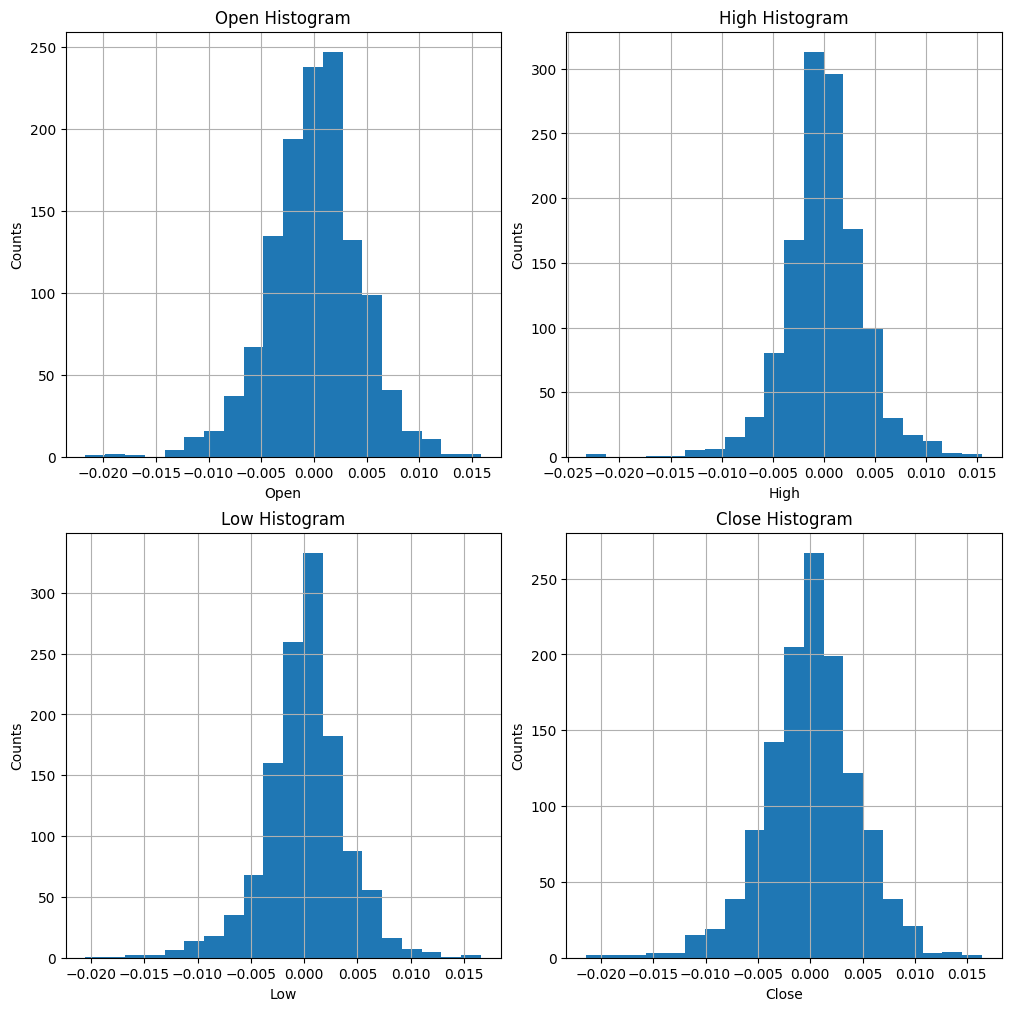

In [144]:
fig, axes = plt.subplots(2,2, figsize = (10,10),constrained_layout=True)

plt.subplot(2,2,1)
df2['Open'].hist(bins=20)
plt.title('Open Histogram')
plt.xlabel('Open')
plt.ylabel('Counts')

plt.subplot(2,2,2)
df2['High'].hist(bins=20)
plt.title('High Histogram')
plt.xlabel('High')
plt.ylabel('Counts')

plt.subplot(2,2,3)
df2['Low'].hist(bins=20)
plt.title('Low Histogram')
plt.xlabel('Low')
plt.ylabel('Counts')

plt.subplot(2,2,4)
df2['Close'].hist(bins=20)
plt.title('Close Histogram')
plt.xlabel('Close')
plt.ylabel('Counts')

plt.show()

From the histograms we can see that values are centered around 0, which is a strong indication that the timeseries might be stationary now. If the data are stationary, then the regressors should perfom much better.

# What would a forecasted Close value 0.01 mean?
In order to answear this we need to invert the log transformation. We see from the following example the actual predicted close value. The close value increased slightly by 1%, as expected by the log return.

In [145]:
predicted_log_close  = 0.01
current_close = 0.95 # example value
actual_predicted_close = current_close * np.exp(predicted_log_close)
actual_predicted_close

np.float64(0.9595476587299595)

In [146]:
train_df = df2[df2['Date']< '2024-01-01']
test_df = df2[df2['Date'].dt.year == 2024]
train_df = train_df.drop(columns=['Date'])
test_df = test_df.drop(columns=['Date'])
x_train , y_train = prepare_data (train_df,5)
x_reshaped = x_train.reshape(x_train.shape[0],-1)
x_test , y_test = prepare_data (test_df,5)
x_test_reshaped = x_test.reshape(x_test.shape[0],-1)

x_reshaped.shape , y_train.shape , x_test_reshaped.shape, y_test.shape

((786, 35), (786,), (247, 35), (247,))

In [147]:
x_train[0] , x_reshaped[0]

(array([[-0.00828359, -0.00783395, -0.00335732, -0.00324741,  0.        ,
          0.        ,  0.        ],
        [-0.00357126,  0.00150715, -0.0005426 ,  0.00540659,  0.        ,
          0.        ,  0.        ],
        [ 0.00562168,  0.00010759,  0.00508853,  0.00021562,  0.        ,
          0.        ,  0.        ],
        [-0.0006471 ,  0.00257813,  0.00010801,  0.00312182,  0.        ,
          0.        ,  0.        ],
        [ 0.0033386 , -0.00075127,  0.00183395, -0.00086023,  0.        ,
          0.        ,  0.        ]]),
 array([-0.00828359, -0.00783395, -0.00335732, -0.00324741,  0.        ,
         0.        ,  0.        , -0.00357126,  0.00150715, -0.0005426 ,
         0.00540659,  0.        ,  0.        ,  0.        ,  0.00562168,
         0.00010759,  0.00508853,  0.00021562,  0.        ,  0.        ,
         0.        , -0.0006471 ,  0.00257813,  0.00010801,  0.00312182,
         0.        ,  0.        ,  0.        ,  0.0033386 , -0.00075127,
         0

In [148]:
reg = LinearRegression().fit(x_reshaped,y_train)
y_pred_reg = reg.predict(x_test_reshaped)
mae_reg_test = mean_absolute_error(y_test, y_pred_reg)
y_pred_reg_train = reg.predict(x_reshaped)
mae_reg_train = mean_absolute_error(y_train, y_pred_reg_train)
print(f'Linear Regressor: Train MAE:{mae_reg_train:.2f} ,Test MAE:{mae_reg_test:.2f} ')

rf = RandomForestRegressor().fit(x_reshaped,y_train)
y_pred_rf = rf.predict(x_test_reshaped)
mae_rf_test = mean_absolute_error(y_test, y_pred_rf)
y_pred_rf_train = rf.predict(x_reshaped)
mae_rf_train = mean_absolute_error(y_train, y_pred_rf_train)
print(f'Random Forest Regressor: Train MAE:{mae_rf_train:.2f} ,Test MAE:{mae_rf_test:.2f} ')

bag = BaggingRegressor().fit(x_reshaped,y_train)
y_pred_bag = bag.predict(x_test_reshaped)
mae_bag_test = mean_absolute_error(y_test, y_pred_bag)
y_pred_bag_train = bag.predict(x_reshaped)
mae_bag_train = mean_absolute_error(y_train, y_pred_bag_train)
print(f'Bagging Regressor: Train MAE:{mae_bag_train:.2f} ,Test MAE:{mae_bag_test:.2f} ')

xb = xgb.XGBRegressor().fit(x_reshaped,y_train)
y_pred_xb = xb.predict(x_test_reshaped)
mae_xb_test = mean_absolute_error(y_test, y_pred_xb)
y_pred_xb_train = xb.predict(x_reshaped)
mae_xb_train = mean_absolute_error(y_train, y_pred_xb_train)
print(f'XGBoost: Train MAE:{mae_xb_train:.2f} ,Test MAE:{mae_xb_test:.2f} ')

estimators = [
    ('lin', LinearRegression()),
    ('dt', DecisionTreeRegressor())
]
sreg = StackingRegressor(estimators=estimators).fit(x_reshaped,y_train)
y_pred_sreg = sreg.predict(x_test_reshaped)
mae_sreg_test = mean_absolute_error(y_test, y_pred_sreg)
y_pred_sreg_train = sreg.predict(x_reshaped)
mae_sreg_train = mean_absolute_error(y_train, y_pred_sreg_train)
print(f'Stacking Regressor: Train MAE:{mae_sreg_train:.2f} ,Test MAE:{mae_sreg_test:.2f} ')

Linear Regressor: Train MAE:0.00 ,Test MAE:0.00 
Random Forest Regressor: Train MAE:0.00 ,Test MAE:0.00 
Bagging Regressor: Train MAE:0.00 ,Test MAE:0.00 
XGBoost: Train MAE:0.00 ,Test MAE:0.00 
Stacking Regressor: Train MAE:0.00 ,Test MAE:0.00 


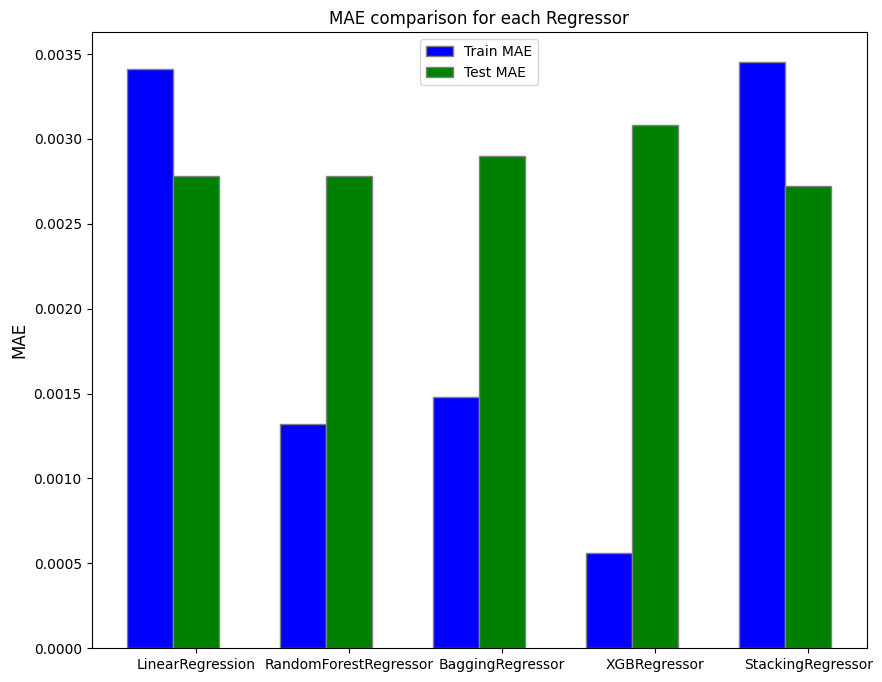

In [149]:
bar_width = 0.3
fig = plt.subplots(figsize =(10, 8))

train_errors = [mae_reg_train , mae_rf_train, mae_bag_train, mae_xb_train, mae_sreg_train]
test_errors = [mae_reg_test , mae_rf_test, mae_bag_test, mae_xb_test, mae_sreg_test]

names = ['LinearRegression', 'RandomForestRegressor', 'BaggingRegressor', 'XGBRegressor', 'StackingRegressor']

bar1 = np.arange(len(train_errors))
bar2 = [x + bar_width for x in bar1]

plt.bar(bar1, train_errors, color ='b', width = bar_width,edgecolor ='grey', label ='Train MAE')
plt.bar(bar2, test_errors, color ='g', width = bar_width,edgecolor ='grey', label ='Test MAE')

plt.ylabel('MAE', fontsize = 12)
plt.xticks([b + bar_width for b in range(len(train_errors))], names)
plt.title("MAE comparison for each Regressor")

plt.legend()
plt.show()

We can observe that the Stacking regressor is the best model.

In [150]:
estimators = [
    ('lin', LinearRegression()),
    ('dt', DecisionTreeRegressor())
]
sreg = StackingRegressor(estimators=estimators).fit(x_reshaped,y_train)

y_pred_sreg = sreg.predict(x_test_reshaped)
previous_values = x_test[:,-1,3] # previous value to reverse transformation
y_pred_sreg = np.exp(previous_values + y_pred_sreg)  # because the previous values are also in log form
y_test = np.exp(previous_values + y_test)
mae_sreg_test = mean_absolute_error(y_test, y_pred_sreg)

y_pred_sreg_train = sreg.predict(x_reshaped)
previous_values = x_train[:,-1,3] # previous value to reverse transformation
y_pred_sreg_train = np.exp(previous_values+y_pred_sreg_train) # because the previous values are also in log form
y_train = np.exp(previous_values+y_train)
mae_sreg_train = mean_absolute_error(y_train, y_pred_sreg_train)
print(f'Stacking Regressor: Train MAE:{mae_sreg_train:.2f} ,Test MAE:{mae_sreg_test:.2f} ')


Stacking Regressor: Train MAE:0.00 ,Test MAE:0.00 


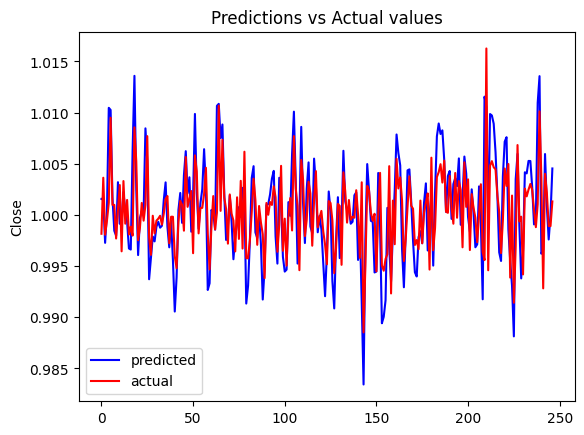

In [151]:
plt.plot(y_test, color = 'b')
plt.plot(y_pred_sreg, color = 'r')
plt.title("Predictions vs Actual values")
plt.legend(['predicted','actual'])
plt.ylabel('Close')
plt.show()

After reversing the transformation we can see that the predicted and the actual timeseries are very close when examining them visually. There might be an error in the transformation process as we see values are much lower than in the original dataset.